In [1]:
import sys
import torch

sys.path.append("/workspace/kbqa/")  # go to parent dir
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [2]:
import datetime

now = datetime.datetime.now()
now

datetime.datetime(2024, 2, 15, 8, 58, 11, 291687)

In [3]:
sequences = True
finetune = True
with_tdidf = False
num_iters = 100000
result_out = f"results/results_no_tfidf_new_seq_{now.time()}.txt"
save_path = "/workspace/storage/misc/features_reranking/best_model_no_tfif_new_seq"

In [4]:
from ast import literal_eval
import pandas as pd


def try_literal_eval(s):
    try:
        return literal_eval(s)
    except ValueError:
        return s

In [5]:
import numpy as np


def arr_to_str(arr):
    arr = list(arr)
    return ",".join(str(a) for a in arr)


def str_to_arr(str):
    arr = str.split(",")
    arr = [float(a) for a in arr]
    return np.array(arr)

### Reading and Processing the Data

In [6]:
print("reading train and test")
processed_train_df = pd.read_csv(
    "/workspace/storage/misc/features_reranking/features_train_new_seqs.csv"
)
processed_test_df = pd.read_csv(
    "/workspace/storage/misc/features_reranking/features_test_new_seqs.csv"
)

reading train and test


In [7]:
def get_numeric_cols(df):
    """return all cols with numeric features"""
    cols_numeric = []
    for k, v in df.dtypes.to_dict().items():
        if (v is np.dtype("int64") or v is np.dtype("float64")) and k != "correct":
            cols_numeric.append(k)

    return cols_numeric

In [8]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()


def apply_col_scale(df, col):
    """apply min max scaling"""
    df[col] = min_max_scaler.fit_transform(df[col])
    return df


# get the numerica cols in train and test to scale
train_numeric_cols = get_numeric_cols(processed_train_df)
test_numeric_cols = get_numeric_cols(processed_test_df)

processed_train_df = apply_col_scale(processed_train_df, train_numeric_cols)
processed_test_df = apply_col_scale(processed_test_df, test_numeric_cols)

In [9]:
processed_train_df.head(3)

,question,question_answer,num_nodes,num_edges,density,cycle,bridge,katz_centrality,page_rank,avg_ssp_length,graph_sequence,graph_sequence_embedding,updated_graph_sequence_embedding,question_answer_embedding,tfidf_vector,correct,updated_graph_sequence
0,What is the seventh tallest mountain in North ...,What is the seventh tallest mountain in North ...,0.0,0.000000,0.217391,0.000000,0.0625,0.874914,0.53152,0.0,"Mount Rainier,continent,North America","0.034756005,-0.023538165,-0.01432218,0.0284024...","0.0307673,0.009273613,-0.018254131,0.04655365,...","0.010093523,0.0059077474,-0.0011233741,0.02769...","7.074399696475794,7.029381555603603,6.89603869...",0.0,Mount Rainier is located in North America.
1,What is the seventh tallest mountain in North ...,What is the seventh tallest mountain in North ...,0.0,0.017857,0.478261,0.001898,0.0625,0.938945,0.76576,0.0,"North America,shares border with,Eurasia,Euras...","0.006314811,0.013446206,-0.030191861,-0.004628...","0.0018651504,0.018196316,-0.014988141,-0.01599...","0.021559492,-0.003825337,-0.0013305206,0.00150...","7.074399696475794,7.029381555603603,6.89603869...",0.0,North America and Eurasia share a border.
2,What is the seventh tallest mountain in North ...,What is the seventh tallest mountain in North ...,0.0,0.035714,0.739130,0.003795,0.0625,0.938945,0.76576,0.0,"North America,has part(s),Greenland,Greenland,...","0.024753027,-0.004211257,-0.042537164,-0.03131...","0.02677703,0.013835486,-0.029348638,-0.0018101...","0.024931252,0.007847421,-0.010111074,-5.701548...","7.074399696475794,7.029381555603603,6.89603869...",0.0,Greenland is part of North America.


In [15]:
# make sure text features are str dtype
def process_text_features(df, text_features):
    for text_feat in text_features:
        df[text_feat] = df[text_feat].astype("string")
    return df


text_features = ["question_answer", "graph_sequence", "updated_graph_sequence"]
processed_train_df = process_text_features(processed_train_df, text_features)
processed_test_df = process_text_features(processed_test_df, text_features)

processed_train_df = processed_train_df.dropna()
processed_test_df = processed_test_df.dropna()

In [16]:
processed_train_df.head(3)

,question,question_answer,num_nodes,num_edges,density,cycle,bridge,katz_centrality,page_rank,avg_ssp_length,graph_sequence,graph_sequence_embedding,updated_graph_sequence_embedding,question_answer_embedding,tfidf_vector,correct,updated_graph_sequence
0,What is the seventh tallest mountain in North ...,What is the seventh tallest mountain in North ...,0.0,0.000000,0.217391,0.000000,0.0625,0.874914,0.53152,0.0,"Mount Rainier,continent,North America","0.034756005,-0.023538165,-0.01432218,0.0284024...","0.0307673,0.009273613,-0.018254131,0.04655365,...","0.010093523,0.0059077474,-0.0011233741,0.02769...","7.074399696475794,7.029381555603603,6.89603869...",0.0,Mount Rainier is located in North America.
1,What is the seventh tallest mountain in North ...,What is the seventh tallest mountain in North ...,0.0,0.017857,0.478261,0.001898,0.0625,0.938945,0.76576,0.0,"North America,shares border with,Eurasia,Euras...","0.006314811,0.013446206,-0.030191861,-0.004628...","0.0018651504,0.018196316,-0.014988141,-0.01599...","0.021559492,-0.003825337,-0.0013305206,0.00150...","7.074399696475794,7.029381555603603,6.89603869...",0.0,North America and Eurasia share a border.
2,What is the seventh tallest mountain in North ...,What is the seventh tallest mountain in North ...,0.0,0.035714,0.739130,0.003795,0.0625,0.938945,0.76576,0.0,"North America,has part(s),Greenland,Greenland,...","0.024753027,-0.004211257,-0.042537164,-0.03131...","0.02677703,0.013835486,-0.029348638,-0.0018101...","0.024931252,0.007847421,-0.010111074,-5.701548...","7.074399696475794,7.029381555603603,6.89603869...",0.0,Greenland is part of North America.


In [17]:
# dropping tfidf
if not with_tdidf:
    processed_train_df = processed_train_df.drop("tfidf_vector", axis=1)
    processed_test_df = processed_test_df.drop("tfidf_vector", axis=1)
    embedding_features = [
        "graph_sequence_embedding",
        "question_answer_embedding",
        "updated_graph_sequence_embedding",
    ]
else:  # with tfidf
    embedding_features = [
        "graph_sequence_embedding",
        "tfidf_vector",
        "question_answer_embedding",
        "updated_graph_sequence_embedding",
    ]

In [ ]:
# turn str representation of embeddings back to np array
for e_f in embedding_features:
    print(e_f)
    processed_train_df[e_f] = processed_train_df[e_f].apply(str_to_arr)
    processed_test_df[e_f] = processed_test_df[e_f].apply(str_to_arr)

In [12]:
drop_cols = ["correct", "question"]

X_train = processed_train_df.drop(drop_cols, axis=1)
y_train = processed_train_df["correct"].tolist()
X_test = processed_test_df.drop(drop_cols, axis=1)
y_test = processed_test_df["correct"].tolist()

In [13]:
import numpy as np


def find_weight(target):
    """find weight for imbalanced classification"""
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)]
    )
    weight = 1.0 / class_sample_count
    samples_weight = np.array([weight[int(t)] for t in target])

    samples_weight = np.double(samples_weight)
    return samples_weight

#### Catboost

In [ ]:
from catboost import Pool, CatBoostRegressor

learn_pool = Pool(
    X_train,
    y_train,
    text_features=text_features,
    feature_names=list(X_train),
    embedding_features=embedding_features,
    weight=find_weight(y_train),
)

test_pool = Pool(
    X_test,
    y_test,
    text_features=text_features,
    feature_names=list(X_test),
    embedding_features=embedding_features,
    weight=find_weight(y_test),
)

#### Grid search

In [18]:
if finetune:
    print("finetuning")
    params = {
        "learning_rate": [0.03, 0.1],
        "depth": [4, 6, 10],
        "l2_leaf_reg": [5, 7, 9, 11],
    }
    model = CatBoostRegressor()
    grid_search_result = model.grid_search(params, learn_pool)

    lr = grid_search_result["params"]["learning_rate"]
    depth = grid_search_result["params"]["depth"]
    leaf = grid_search_result["params"]["l2_leaf_reg"]
else:
    lr = 0.1
    depth = 6
    leaf = 9

#### Fitting best params

In [19]:
# Initialize CatBoostRegressor
model = CatBoostRegressor(
    iterations=num_iters,
    learning_rate=lr,
    depth=depth,
    l2_leaf_reg=leaf,
    # task_type="GPU",
    #early_stopping_rounds=100,
    eval_metric="RMSE",
)

print("training")
model.fit(learn_pool, eval_set=test_pool, verbose=200)
model.save_model(save_path)

training
0:	learn: 0.4922326	test: 0.4906605	best: 0.4906605 (0)	total: 149ms	remaining: 596ms
1:	learn: 0.4857855	test: 0.4827708	best: 0.4827708 (1)	total: 242ms	remaining: 363ms
2:	learn: 0.4802756	test: 0.4760749	best: 0.4760749 (2)	total: 340ms	remaining: 226ms
3:	learn: 0.4756756	test: 0.4719793	best: 0.4719793 (3)	total: 430ms	remaining: 107ms
4:	learn: 0.4713540	test: 0.4680634	best: 0.4680634 (4)	total: 523ms	remaining: 0us

bestTest = 0.4680633817
bestIteration = 4



#### Reranking Results

In [17]:
from datasets import load_dataset

test_res_csv = load_dataset(
    f"hle2000/Mintaka_T5_xl_ssm_outputs", verification_mode="no_checks"
)["test"].to_pandas()
test_res_csv.head()

Found cached dataset parquet (/root/.cache/huggingface/datasets/hle2000___parquet/hle2000--Mintaka_T5_xl_ssm_outputs-9a78025ce7d9a549/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/2 [00:00<?, ?it/s]

,question,target,answer_0,answer_1,answer_2,answer_3,answer_4,answer_5,answer_6,answer_7,...,answer_192,answer_193,answer_194,answer_195,answer_196,answer_197,answer_198,answer_199,target_out_of_vocab,__index_level_0__
0,What man was a famous American author and also...,Mark Twain,Mark Twain,Mark Twain,Mark Twain,Mark Twain,Mark Twain,Mark Twain,Mark Twain,Mark Twain,...,Louisa May Alcott,Ambrose Bierce,Ishmael Lehman,"Mark Twain, Natchez, Missouri","Mark Twain, Louisa",Ishmael Levy,Ishmael Beam,"Mark Twain, Natchez, Mississippi",False,0
1,How many Academy Awards has Jake Gyllenhaal be...,1,3,2,3,2,3,2,3,2,...,13,12,8,11,10,6,9,13,False,1
2,"Who is older, The Weeknd or Drake?",Drake,The Weeknd,The Weeknd,The Weeknd,The Weeknd,The Weeknd,The Weeknd,The Weeknd,The Weeknd,...,The Weeknd (2017),The Weeknd's oldest,The Weeknd is older than Drake,The Weeknd's,Dierks Bentley,"The Weeknd""",Drake & The Weeknd,The Weeknd's age,False,2
3,How many children did Donald Trump have?,5,5,5,3,5,3,5,3,5,...,24,6,76,13,61,108,0,8,False,3
4,Is the main hero in Final Fantasy IX named Kuja?,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,...,Is it a Final Fantasy,Does it include Kuja?,Is it,Is he Kuja,Is it No,Y Yes,Is Kuja,Is he called Kuja,False,4


In [19]:
from tqdm import tqdm

final_acc, top200_total, top1_total, seq2seq_correct = 0, 0, 0, 0

for idx, group in tqdm(test_res_csv.iterrows()):
    curr_question_df = processed_test_df[
        processed_test_df["question"] == group["question"]
    ]
    curr_question_df = curr_question_df.drop("question", axis=1)

    if (
        len(curr_question_df) == 0
    ):  # we don't have subgraph for this question, take answer from seq2seq
        if group["answer_0"] == group["target"]:
            seq2seq_correct += 1
        else:  # check if answer exist in 200 beams for question with no subgraphs
            all_beams = group.tolist()[2:-1]  # all 200 beams
            all_beams = set(all_beams)
            top200_total += 1 if group["target"] in all_beams else 0

    else:  # we have subgraph for this question
        all_beams = group.tolist()[2:-1]  # all 200 beams
        all_beams = set(all_beams)

        if group["target"] not in all_beams:  # no correct answer in beam
            continue

        # correct answer exist in beam
        top1_total += 1 if group["answer_0"] == group["target"] else 0
        top200_total += 1

        is_corrects = curr_question_df["correct"].astype(bool).tolist()
        # drop seq if we're not using it
        drop_cols = ["correct", "graph_sequence"] if not sequences else ["correct"]
        curr_rows = curr_question_df.drop(drop_cols, axis=1)

        preds = model.predict(curr_rows)
        max_idx = preds.argmax()

        if is_corrects[max_idx] is True:
            final_acc += 1


# final rerankinga, top1 and top200 result
reranking_res = (final_acc + seq2seq_correct) / len(test_res_csv)
top200 = (top200_total + seq2seq_correct) / len(test_res_csv)
top1 = (top1_total + seq2seq_correct) / len(test_res_csv)

with open(result_out, "w+") as f:
    f.write(f"top1: {top1}, top200: {top200}, reranking top1: {reranking_res}")
print(f"top1: {top1}, top200: {top200}, reranking top1: {reranking_res}")

4000it [00:25, 157.69it/s]

top1: 0.31725, top200: 0.69025, reranking top1: 0.3245


#### Features Importance

<BarContainer object of 14 artists>

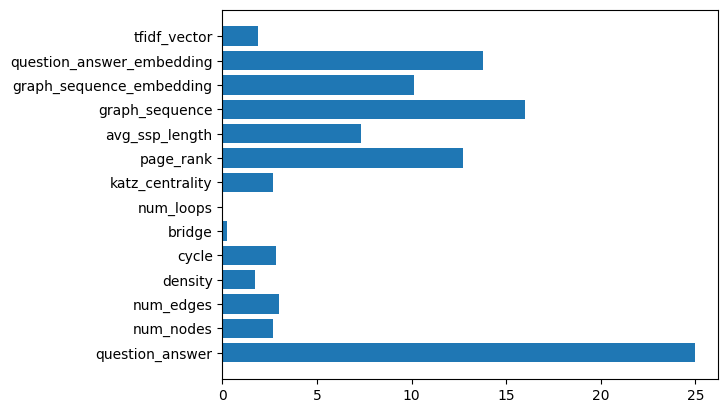

In [20]:
import matplotlib.pyplot as plt

col_names = X_test.columns.tolist()
features_importance = model.get_feature_importance(data=test_pool)

plt.barh(col_names, features_importance)